
# Fitting a Gaussian Process Operator with Linox



This walkthrough shows how to build a Gaussian process (GP) operator with **Linox**.
We will

1. generate synthetic 2D heat-equation data,
2. define a modular GP prior,
3. fit the operator to the data, and
4. visualise predictions, uncertainty, and posterior samples.


In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import linox as lo
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from helper.plotting import (
    generate_preprocess_data_2d,
    plot_kernel_predictions_2d,
    plot_uncertainty_2d,
)
from helper.gp import KernelType, CombinationStrategy
from helper.new_gp import (
    CombinationConfig,
    DimensionSpec,
    ModularGPPrior,
    StructureConfig,
    params_from_structure,
)

jax.config.update("jax_enable_x64", True)
plt.style.use("seaborn-v0_8")


## 1. Generate training and evaluation data

We draw random initial conditions, solve the heat equation analytically, and
create train/test splits together with a dense grid used for plotting.


In [3]:
x_range = (0.0, np.pi)
y_range = (0.0, np.pi)
nx = ny = 12
nx_plot = ny_plot = 20
T = 0.1
alpha_value = 0.5
N_train = 40
N_test = 3

(
    operator_inputs,
    spatial_inputs,
    outputs,
    operator_inputs_test,
    spatial_inputs_test,
    outputs_test,
    spatial_inputs_plot,
) = generate_preprocess_data_2d(
    x_range=x_range,
    y_range=y_range,
    nx=nx,
    ny=ny,
    T=T,
    alpha=alpha_value,
    N_train=N_train,
    N_test=N_test,
    nx_plot=nx_plot,
    ny_plot=ny_plot,
)

operator_inputs = operator_inputs.reshape(N_train, nx, ny)
spatial_inputs = spatial_inputs.reshape(nx, ny, 2)
operator_inputs_test = operator_inputs_test.reshape(N_test, nx, ny)
spatial_inputs_test = spatial_inputs_test.reshape(nx, ny, 2)
spatial_inputs_plot = spatial_inputs_plot.reshape(nx_plot, ny_plot, 2)

print(f"operator_inputs: {operator_inputs.shape}")
print(f"spatial_inputs: {spatial_inputs.shape}")
print(f"outputs: {outputs.shape}")

Generating 2D training data...
Generating 2D test data...
operator_inputs: (40, 12, 12)
spatial_inputs: (12, 12, 2)
outputs: (40, 144)



## 2. Configure the modular GP prior

The prior is specified by separate kernels for the spatial input dimensions and the
function space (initial conditions). Hyperparameters are stored in a structured dictionary
so that they can be optimised later if needed.


In [4]:
structure_config = StructureConfig(
    spatial_dims=[
        DimensionSpec(name="x", kernel_type=KernelType.RBF),
        DimensionSpec(name="y", kernel_type=KernelType.RBF),
    ],
    function_dims=[DimensionSpec(name="u", kernel_type=KernelType.L2)],
)

combination_config = CombinationConfig(
    strategy=CombinationStrategy.ADDITIVE,
    noise_variance=1e-6,
    output_scale=1.0,
)

prior = ModularGPPrior(structure_config, combination_config)
params = params_from_structure(structure_config)
params

{'spatial_x': {'lengthscale': Array(0.15707963, dtype=float64, weak_type=True)},
 'spatial_y': {'lengthscale': Array(0.15707963, dtype=float64, weak_type=True)},
 'function_u': {'bias': Array(-1., dtype=float64, weak_type=True)},
 'output_scale': Array(0., dtype=float64, weak_type=True),
 'noise_variance': Array(-6., dtype=float64, weak_type=True)}


## 3. Fit the operator and predict on new inputs

We build the training kernel, solve the linear system for the GP weights, and evaluate
predictions and uncertainty on a denser grid.


In [ ]:
# Flatten the training outputs once for convenience
outputs_flat = outputs.reshape(-1, 1)

pred_mean_flat, pred_cov = prior.predict(
    operator_inputs,
    outputs,
    spatial_inputs,
    operator_inputs_test,
    spatial_inputs_plot,
    params,
)

pred_mean_flat = pred_mean_flat.reshape(N_test, -1)
pred_cov = pred_cov.todense().reshape(
    N_test, ny_plot * nx_plot, N_test, ny_plot * nx_plot
)



## 4. Visualise predictions, uncertainty, and posterior samples


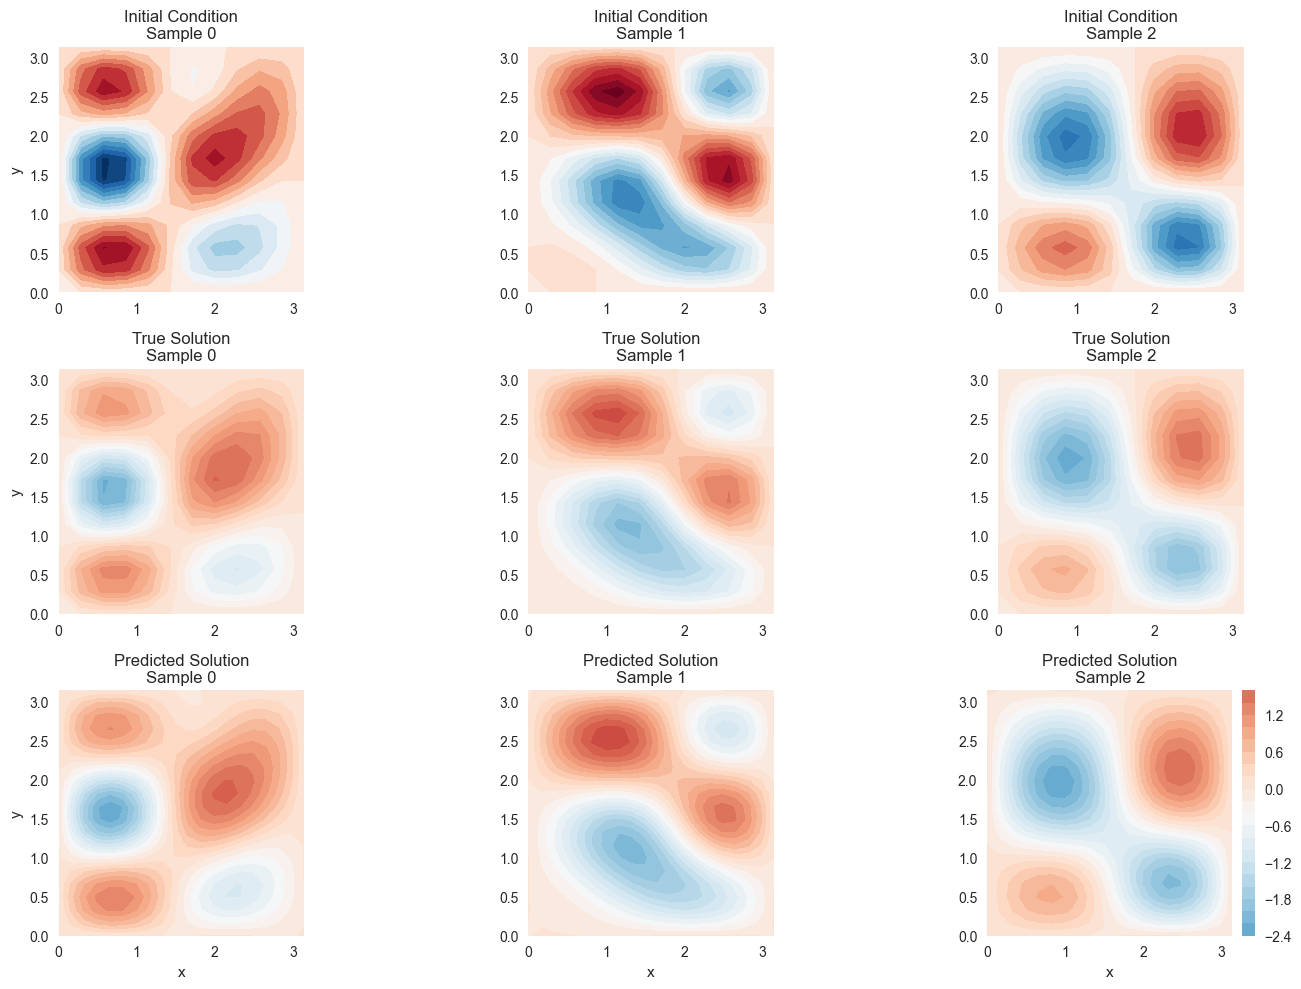

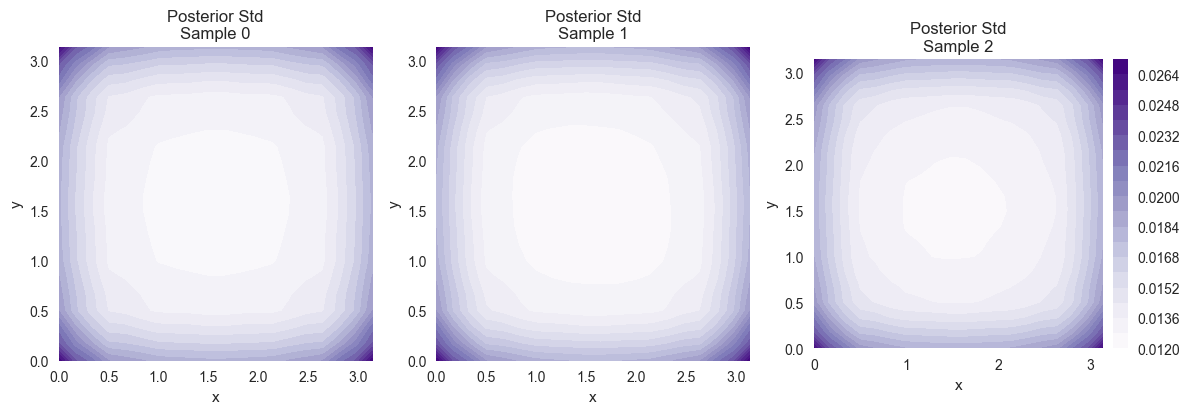

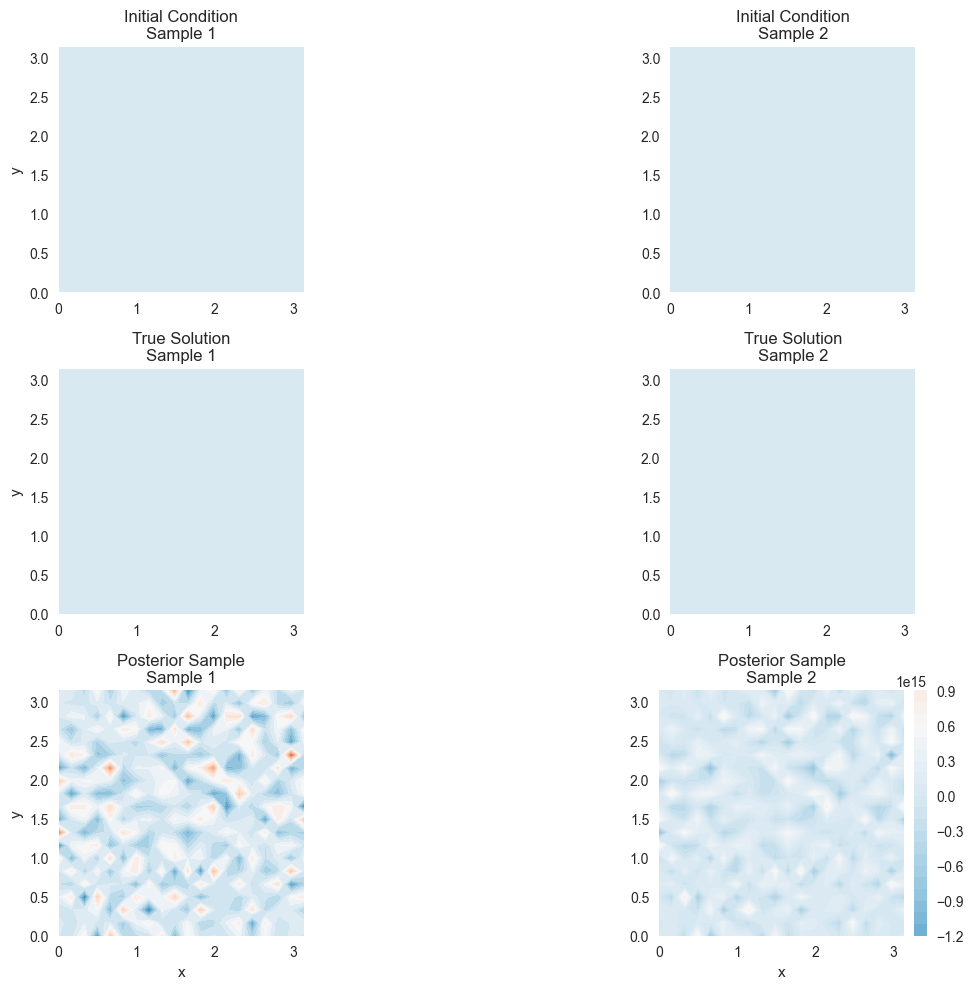

In [ ]:
_ = plot_kernel_predictions_2d(
    pred_mean_flat,
    outputs_test,
    operator_inputs_test.reshape(N_test, -1),
    spatial_inputs_plot.reshape(-1, 2),
    spatial_inputs_test.reshape(-1, 2),
    nx,
    ny,
    nx_plot,
    ny_plot,
    N_test,
)
plt.show()

_ = plot_uncertainty_2d(
    pred_cov,
    spatial_inputs_plot.reshape(-1, 2),
    nx_plot,
    ny_plot,
    N_test,
)
plt.show()
